# SEMITONES application - 10x Genomics multiome BMMC

In [39]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import seaborn as sns
from matplotlib.lines import Line2D
from random import shuffle
from sklearn.preprocessing import binarize
from sklearn.metrics.pairwise import pairwise_kernels
from SEMITONES.cell_selection import from_knn_dist
from SEMITONES.support_funcs import sig_dictionary
from SEMITONES.support_funcs import sig_bool
from SEMITONES.enrichment_scoring import sig_interval
from scipy import stats

In [2]:
adata_rna = sc.read_h5ad('../processed/10X_multiome/pbmc_rna.h5ad')
# cpm normalization of RNA
norm_rna = sc.pp.normalize_total(adata_rna, target_sum=1e6, copy=True)
sc.pp.log1p(norm_rna)
adata_rna.layers['lognorm_rna'] = norm_rna.X

In [3]:
adata_atac = sc.read_h5ad('../processed/10X_multiome/pbmc_atac.h5ad')

# binarize
adata_atac.layers['b_atac'] = binarize(adata_atac.X)

In [4]:
wnn_umap2= np.genfromtxt('../processed/10X_multiome/wnn_umap.csv', delimiter=',')
wnn_umap25= np.genfromtxt('../processed/10X_multiome/wnn_umap25.csv', delimiter=',')

In [28]:
# determine gamma, select the gamma value that the most cell types are covered by at least one reference cell
def n_rcell(g):
    
    S = pairwise_kernels(wnn_umap25, metric='rbf',gamma=g)
    median = np.median(S, axis=0)
    start = int(np.argmin(median))

    dd_rcells = from_knn_dist(X=wnn_umap25,
                             n_ret=100,
                             start=start,
                             metric='rbf',
                             metric_params={"gamma": g})
    r_cell_type=adata_atac.obs['predicted.id'][dd_rcells]
    res = r_cell_type.unique().shape[0]
    return res

nl = []
gl = []
# because this step is time consuming, we took a smaller range of gamma as example
for g in np.arange(0.6,0.99,0.01):
    nl.append(n_rcell(g))
    gl.append(g)

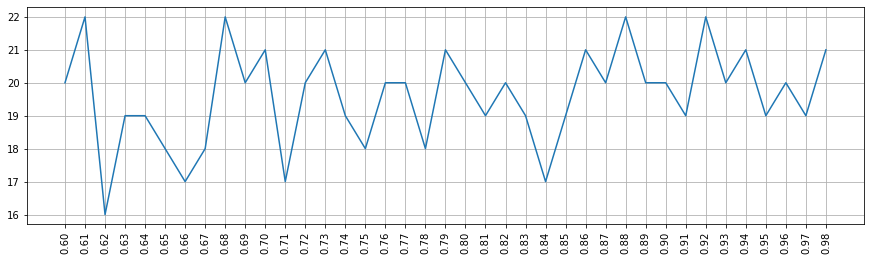

In [30]:
plt.figure(figsize=(15,4))
plt.plot(gl,nl)
plt.xticks(np.arange(0.6, 0.99, 0.01), rotation=90)
plt.grid()
plt.show()

In [31]:
# check the selected reference cells
g=0.68

S = pairwise_kernels(wnn_umap25, metric='rbf',gamma=g)
median = np.median(S, axis=0)
start = int(np.argmin(median))

dd_rcells = from_knn_dist(X=wnn_umap25,
                         n_ret=100,
                         start=start,
                         metric='rbf',
                         metric_params={"gamma": g})

In [32]:
# the numbers of reference cells in each cell type
r_cell_type=adata_atac.obs['predicted.id'][dd_rcells]
r_cell_type.value_counts()

CD14 Mono           24
CD4 TCM             13
CD8 Naive           12
CD4 Naive           10
CD16 Mono            5
CD8 TEM              5
B intermediate       4
B naive              4
Eryth                4
NK                   4
CD4 TEM              2
gdT                  2
Treg                 2
cDC2                 1
cDC1                 1
B memory             1
pDC                  1
CD4 CTL              1
Plasmablast          1
CD8 TCM              1
NK Proliferating     1
HSPC                 1
Name: predicted.id, dtype: int64

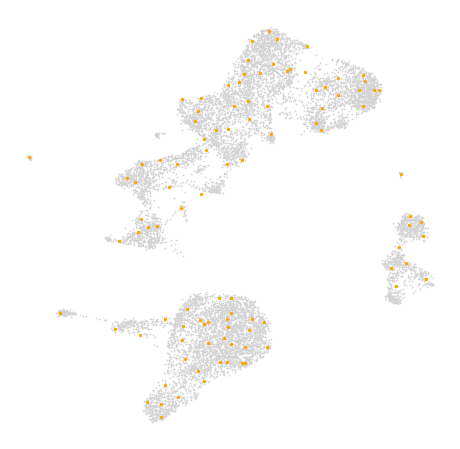

In [33]:
plt.figure(figsize=(8,8))
plt.scatter(wnn_umap2[:,0],wnn_umap2[:,1],s=0.5,c='lightgrey')
plt.scatter(wnn_umap2[dd_rcells, 0], wnn_umap2[dd_rcells, 1], s=5, c='orange')
plt.axis('off')
plt.show()

Run 10X_scores.py to calculate SEMITONES enrichment scores and permutation scores.

In [34]:
ATAC_es = pd.read_hdf('../processed/10X_multiome/ATAC_escore.h5','escores')
ATAC_ps = pd.read_hdf('../processed/10X_multiome/ATAC_pscore.h5','pscores')

In [35]:
# determine the significantly enriched features
ATAC_interval = sig_interval(ATAC_ps, n_sds=10)
ATAC_sigdict_acc = sig_dictionary(ATAC_es, ATAC_interval, sign='positive')
ATAC_sigdict_inacc = sig_dictionary(ATAC_es, ATAC_interval, sign='negative')
ATAC_sigdict = sig_dictionary(ATAC_es, ATAC_interval)

In [37]:
# load Homer annotation
ann = pd.read_csv('../processed/10X_multiome/ATAC_ann.txt', sep='\t', index_col=0)
ann.sort_index(inplace=True)
ann.reset_index(drop=True, inplace=True)

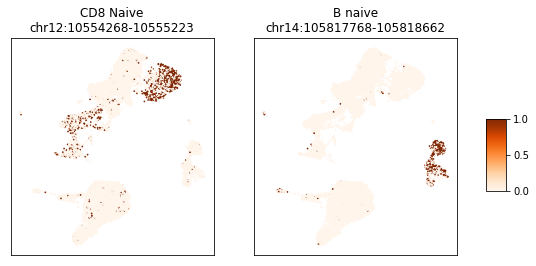

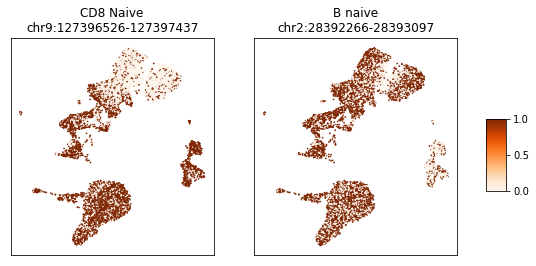

In [40]:
# examples of selectively accessible regions and selectively inaccessible regions identified by SEMITONES
names = ann['Chr']+':'+ann['Start'].astype(str)+'-'+ann['End'].astype(str)

def top_one_plots(rcells_list, acc='acc'):
    fig, axs = plt.subplots(1,len(rcells_list), figsize=(4*len(rcells_list),4))
    for ax,rcell in zip(axs, rcells_list):
        
        if acc=='acc':
            # selectively acc
            index = ATAC_es[rcell].rank(ascending=False).sort_values().index[0]
        else:
            # selectively inacc
            index = ATAC_es[rcell].rank(ascending=True).sort_values().index[0]

        ct = adata_atac.obs['predicted.id'][rcell]
        ft = names[index]

        colors = adata_atac.layers['b_atac'][:,index].todense().tolist()
        ax.scatter(wnn_umap2[:,0], wnn_umap2[:,1], c=colors, cmap='Oranges', s=0.5)
        ax.set_title('{}\n{}'.format(ct, ft))
        ax.set_xticks([])
        ax.set_yticks([])
    sm =  ScalarMappable(norm=plt.Normalize(0, 1), cmap='Oranges')
    sm.set_array([])
    # [left, bottom, width, height]
    cax = plt.axes([0.95, 0.35, 0.035, 0.25])
    cbar = fig.colorbar(sm, ax=axs, cax=cax)
    fig.savefig('../figures/SEMITONES/10X_{}_umap.png'.format(acc), bbox_inches='tight')
    plt.show()

#rcell = escores.columns[2]
top_one_plots([ATAC_es.columns[14], ATAC_es.columns[15]], acc='acc')
top_one_plots([ATAC_es.columns[14], ATAC_es.columns[15]], acc='inacc')